In [ ]:
from google.colab import files
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


dataset_path = "/content/household_power_consumption.txt"

# Load dataset efficiently
use_cols = [
    "Date", "Time", "Global_active_power", "Global_reactive_power",
    "Voltage", "Global_intensity", "Sub_metering_1",
    "Sub_metering_2", "Sub_metering_3"
]
dtype_map = {col: "float32" for col in use_cols[2:]}
df = pd.read_csv(dataset_path, sep=";", usecols=use_cols, na_values="?", dtype=dtype_map)
df.dropna(inplace=True)

# Datetime index
df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df.set_index("DateTime", inplace=True)
df.drop(columns=["Date","Time"], inplace=True)
df.sort_index(inplace=True)

# Features
df["hour"] = df.index.hour.astype("int8")
df["day_of_week"] = df.index.dayofweek.astype("int8")
df["is_weekend"] = (df["day_of_week"] >=5).astype("int8")
df["lag1"] = df["Global_active_power"].shift(1).astype("float32")
df["lag2"] = df["Global_active_power"].shift(2).astype("float32")
df.dropna(inplace=True)

features = ["Voltage","Global_reactive_power","Sub_metering_1","Sub_metering_2","Sub_metering_3",
            "hour","day_of_week","is_weekend","lag1","lag2"]
target = "Global_active_power"

X = df[features]
y = df[target]


# 80:20 time-based split
cutoff = int(len(X)*0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

# Random Forest
model = RandomForestRegressor(
    n_estimators=80,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print("Colab Model Evaluation (80 trees)")
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

joblib.dump(model, "/content/rf_model_colab.pkl")
joblib.dump((X_test, y_test, y_pred), "/content/test_outputs_colab.pkl")


Colab Model Evaluation (80 trees)
R²: 0.9714749475739399
MSE: 0.02290109817025663


['/content/test_outputs_colab.pkl']

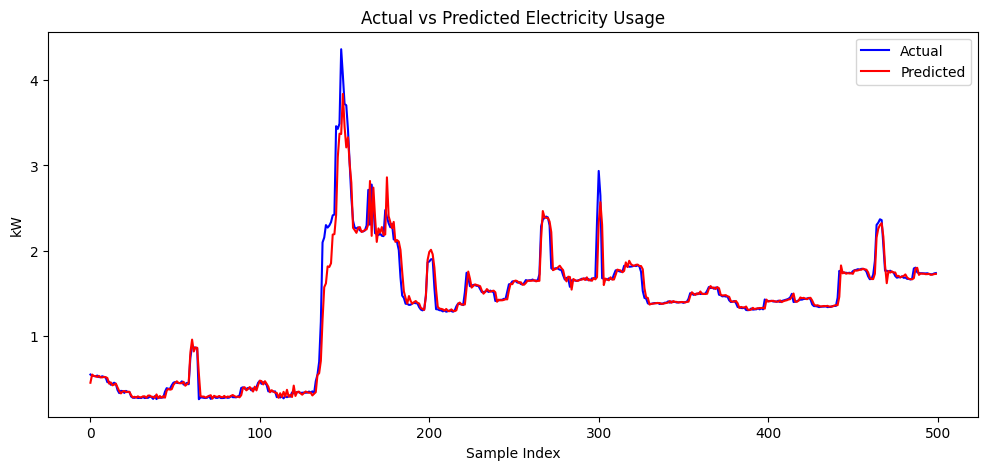

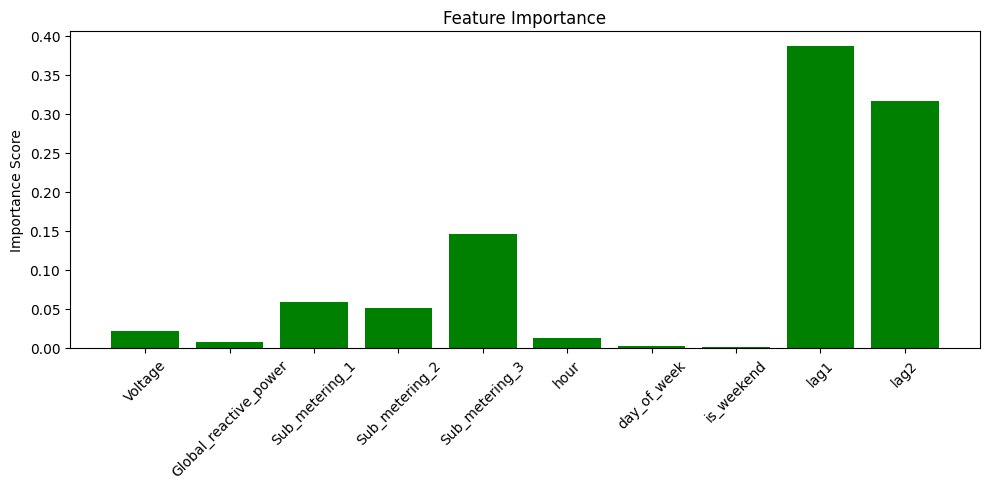

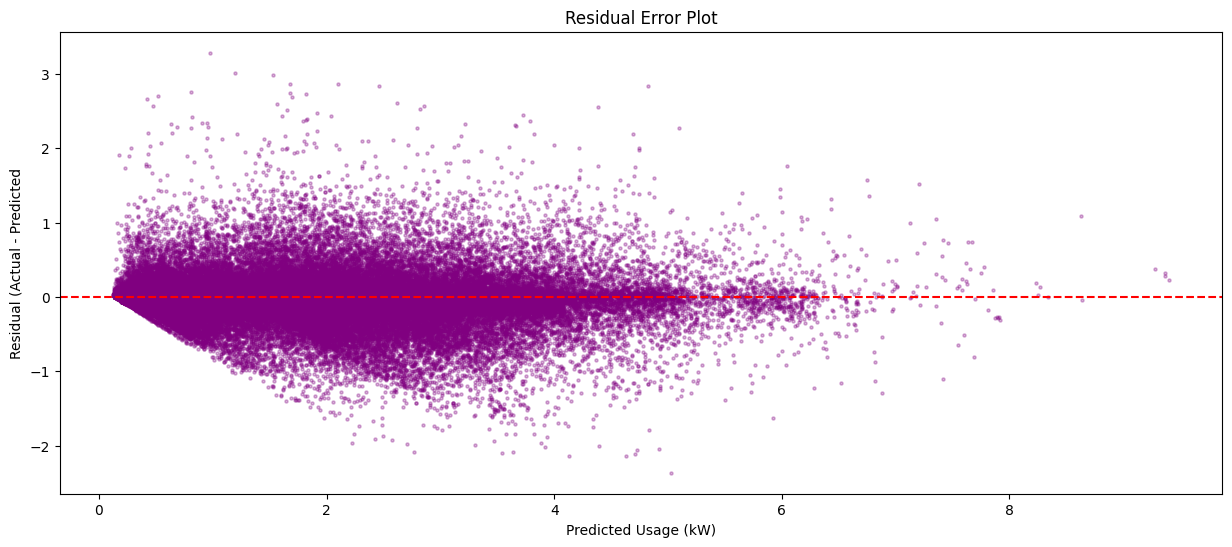

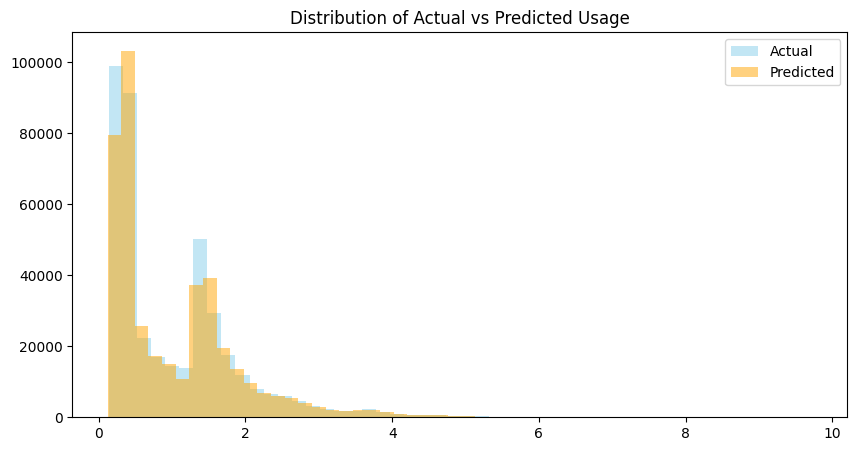

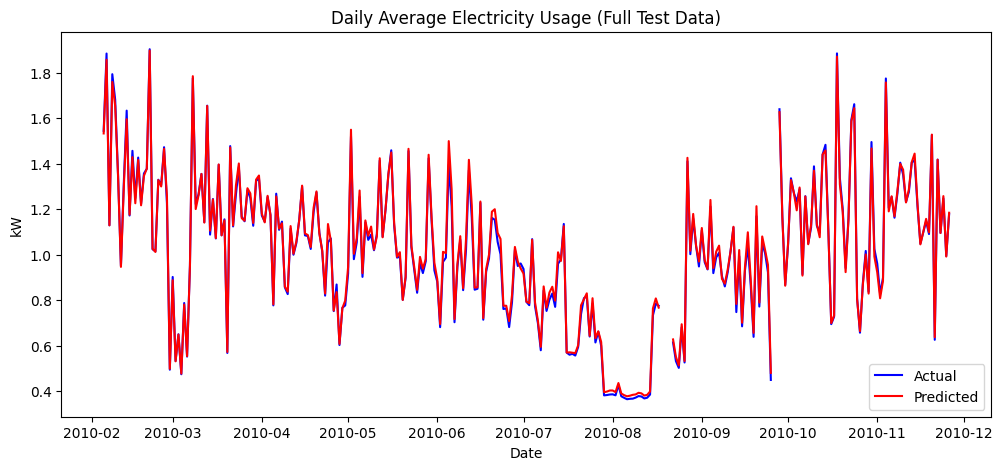


--- Analysis ---
🟡 Good performance: R² = 0.97
📉 MSE: 0.0229
🔥 Top contributing feature: lag1



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error, r2_score


model = joblib.load("/content/rf_model_colab.pkl")
X_test, y_test, y_pred = joblib.load("/content/test_outputs_colab.pkl")

#Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(y_test[:500].values, label="Actual", color="blue")
plt.plot(y_pred[:500], label="Predicted", color="red")
plt.title("Actual vs Predicted Electricity Usage")
plt.xlabel("Sample Index")
plt.ylabel("kW")
plt.legend()
plt.show()

#Feature Importance
importances = model.feature_importances_
plt.figure(figsize=(10,5))
plt.bar(X_test.columns, importances, color='green')
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Full Residual Error Plot
residuals = y_test - y_pred
plt.figure(figsize=(15,6))
plt.scatter(y_pred, residuals, alpha=0.3, color='purple', s=5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Error Plot")
plt.xlabel("Predicted Usage (kW)")
plt.ylabel("Residual (Actual - Predicted")
plt.show()

#Distribution of Actual vs Predicted
plt.figure(figsize=(10,5))
plt.hist(y_test, bins=50, alpha=0.5, label="Actual", color="skyblue")
plt.hist(y_pred, bins=50, alpha=0.5, label="Predicted", color="orange")
plt.title("Distribution of Actual vs Predicted Usage")
plt.legend()
plt.show()

#Daily Average Comparison
daily_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}, index=X_test.index)
daily_avg = daily_df.resample("D").mean()
plt.figure(figsize=(12,5))
plt.plot(daily_avg["Actual"], label="Actual", color="blue")
plt.plot(daily_avg["Predicted"], label="Predicted", color="red")
plt.title("Daily Average Electricity Usage (Full Test Data)")
plt.xlabel("Date")
plt.ylabel("kW")
plt.legend()
plt.show()

#Automatic analysis
def generate_analysis(mse, r2, importances, feature_names):
    analysis = "\n--- Analysis ---\n"
    analysis += f"🟡 Good performance: R² = {r2:.2f}\n"
    analysis += f"📉 MSE: {mse:.4f}\n"
    top_feat = feature_names[np.argmax(importances)]
    analysis += f"🔥 Top contributing feature: {top_feat}\n"
    return analysis

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(generate_analysis(mse, r2, importances, X_test.columns))
